In [1]:
from google.colab import files
uploaded = files.upload()

Saving training.csv to training.csv
Saving features_test.csv to features_test.csv
Saving features_df.csv to features_df.csv
Saving test.csv to test.csv
Saving training_class.csv to training_class.csv


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
import pandas as pd

In [3]:
df = pd.read_csv("training.csv")

In [4]:
print(df.head())

   Unnamed: 0                name  \
0           0  ENSDART00000138379   
1           1  ENSDART00000075994   
2           2  ENSDART00000153938   
3           3  ENSDART00000152541   
4           4  ENSDART00000139170   

                                            Sequence  class  
0  TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...      1  
1  ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...      1  
2  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...      1  
3  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...      1  
4  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...      1  


In [5]:
iupac_encoding = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'U': [0, 0, 0, 1],
    'R': [0.5, 0, 0.5, 0],
    'Y': [0, 0.5, 0, 0.5],
    'S': [0, 0.5, 0.5, 0],
    'W': [0.5, 0, 0, 0.5],
    'K': [0, 0, 0.5, 0.5],
    'M': [0.5, 0.5, 0, 0],
    'B': [0, 1/3, 1/3, 1/3],
    'D': [1/3, 0, 1/3, 1/3],
    'H': [1/3, 1/3, 0, 1/3],
    'V': [1/3, 1/3, 1/3, 0],
    'N': [0.25, 0.25, 0.25, 0.25],
    '.': [0, 0, 0, 0],
    '-': [0, 0, 0, 0]
}

In [6]:
def encode_sequence(seq):
    return np.array([iupac_encoding.get(base, [0, 0, 0, 0]) for base in seq], dtype='float32')

In [7]:
#encode X from letters to array of numbers
X = [encode_sequence(seq) for seq in df['Sequence']]
y = df['class'].values

In [8]:
# pad to same length

maxlen = 500


X = pad_sequences(X, maxlen=maxlen, padding='post', dtype='float32')

In [9]:
## Building LSTM model
def create_model(lstm_units, dropout_rate, learning_rate):
  model = Sequential([
      Input(shape = (500, 4)),
      LSTM(lstm_units, return_sequences = False),
      Dropout(dropout_rate),
      Dense(1, activation = 'sigmoid')
  ])

  model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
  )

  return model


In [10]:
## Caculate the metrics
def calculate_metrics(y_true, y_pred_proba):
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'f1_score': f1_score(y_true, y_pred_binary, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
    }

    #Confusion matrix components
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    metrics.update({
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
    })

    return metrics


In [11]:
# Try 4 different configurations
configs = [
    {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001,
     'batch_size': 32, 'epochs': 10},

    {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001,
     'batch_size': 32, 'epochs': 10},

    {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001,
     'batch_size': 16, 'epochs': 15},

    {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001,
     'batch_size': 16, 'epochs': 10},
]

In [13]:
##Training model
results = []

for idx, config in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Model {idx + 1}/4: {config}")
    print(f"{'='*60}")

    model = create_model(
        lstm_units=config['lstm_units'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate'],
        # optimizer_name=config['optimizer']
    )

    history = model.fit(
        X, y,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        verbose=1
    )

    y_pred_proba = model.predict(X, verbose=0).flatten()
    metrics = calculate_metrics(y, y_pred_proba)\

    result = {**config, **metrics}
    results.append(result)

    print(f"\nResults:")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")
    print(f"  F1 Score:    {metrics['f1_score']:.4f}")
    print(f"  ROC AUC:     {metrics['roc_auc']:.4f}")
    print(f"  Specificity: {metrics['specificity']:.4f}")
    print(f"  TP: {metrics['true_positive']}, TN: {metrics['true_negative']}, "
          f"FP: {metrics['false_positive']}, FN: {metrics['false_negative']}")


Model 1/4: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}
Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 88s 191ms/step - accuracy: 0.6597 - loss: 0.6854
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.6529 - loss: 0.5838
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 78s 173ms/step - accuracy: 0.6602 - loss: 0.5356
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.6747 - loss: 0.5088
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 75s 169ms/step - accuracy: 0.6737 - loss: 0.4999
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.6809 - loss: 0.5043
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 84s 170ms/step - accuracy: 0.6823 - loss: 0.4971
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 74s 166ms/step - accuracy: 0.6909 - loss: 0.4953
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.6849 - loss: 0.4920
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - accuracy: 0.6822 - loss: 0.4993



In [14]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('roc_auc', ascending=False)

In [18]:
print("\n" + "="*60)
print("FINAL RESULTS (sorted by roc_auc)")
print("="*60)
print(results_df[['lstm_units', 'dropout_rate', 'learning_rate', 'batch_size',
                   'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].to_string(index=False))


FINAL RESULTS (sorted by roc_auc)
 lstm_units  dropout_rate  learning_rate  batch_size  accuracy  precision   recall  f1_score  roc_auc
         32           0.2          0.001          32  0.686546   0.539332 0.790992  0.641358 0.778299
         64           0.3          0.001          32  0.702226   0.562655 0.716713  0.630408 0.784117
         64           0.5          0.001          16  0.705866   0.575386 0.648360  0.609697 0.786787
        128           0.2          0.001          16  0.700056   0.606468 0.437179  0.508093 0.789157


In [20]:
print("\n" + "="*60)
print("BEST MODEL:")
print("="*60)
best = results_df.iloc[-1]
print(f"LSTM Units: {best['lstm_units']}")
print(f"Dropout: {best['dropout_rate']}")
print(f"Learning Rate: {best['learning_rate ']}")
print(f"Batch Size: {best['batch_size']}")
print(f"roc_auc: {best['roc_auc']:.4f}")


BEST MODEL:
LSTM Units: 128.0
Dropout: 0.2
Learning Rate: 0.001
Batch Size: 16.0
roc_auc: 0.7892


In [22]:
##Saving model
from tensorflow.keras.models import save_model

# Extract best params
lstm_units = int(best['lstm_units'])
dropout_rate = best['dropout_rate']
learning_rate = best['learning_rate']
batch_size = int(best['batch_size'])
best_model = create_model(
    lstm_units=lstm_units,
    dropout_rate=dropout_rate,
    learning_rate=learning_rate
)
best_model.fit(
    X, y,
    epochs= 12,
    batch_size=batch_size,
    verbose=1
)

best_model.save("LSTM_model.h5")
print("Best model trained and saved as LSTM_model.h5")

Epoch 1/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 263s 292ms/step - accuracy: 0.6619 - loss: 0.5498
Epoch 2/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 269s 301ms/step - accuracy: 0.6431 - loss: 0.6147
Epoch 3/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 266s 298ms/step - accuracy: 0.6568 - loss: 0.5146
Epoch 4/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 264s 296ms/step - accuracy: 0.6657 - loss: 0.5145
Epoch 5/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 262s 294ms/step - accuracy: 0.6603 - loss: 0.5040
Epoch 6/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 262s 293ms/step - accuracy: 0.6734 - loss: 0.5007
Epoch 7/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 264s 296ms/step - accuracy: 0.6775 - loss: 0.4993
Epoch 8/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 321s 295ms/step - accuracy: 0.6746 - loss: 0.5011
Epoch 9/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 319s 291ms/step - accuracy: 0.6853 - loss: 0.4942
Epoch 10/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 263s 293ms/step - accuracy: 0.6911 - loss: 0.5023
Epoch 11/12
893/893 ━━━━━━━━━━━━━━━━━━━━ 262s 293ms/step - accuracy: 0.6945 - loss: 0.4913
Epoch 12

Best model trained and saved as LSTM_model.h5


In [23]:
df_test = pd.read_csv('test.csv')

In [25]:
from tensorflow.keras.models import load_model
model = load_model('LSTM_model.h5')

In [26]:
#Testing
X_test = [encode_sequence(seq) for seq in df_test['sequence']]
y_test = df_test['class'].values

X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', dtype='float32')
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.5806 - loss: 0.6598
Test Accuracy: 0.6019


In [27]:
## Plot metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

138/138 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step


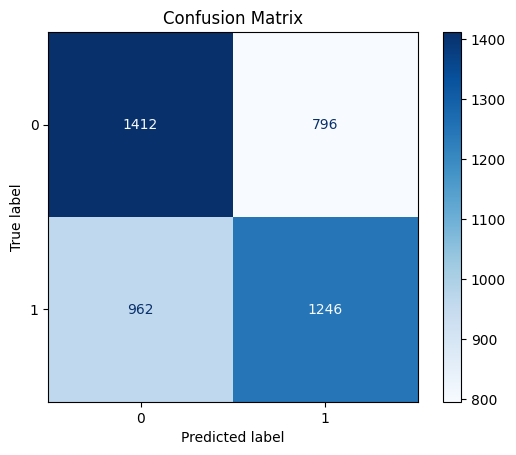

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

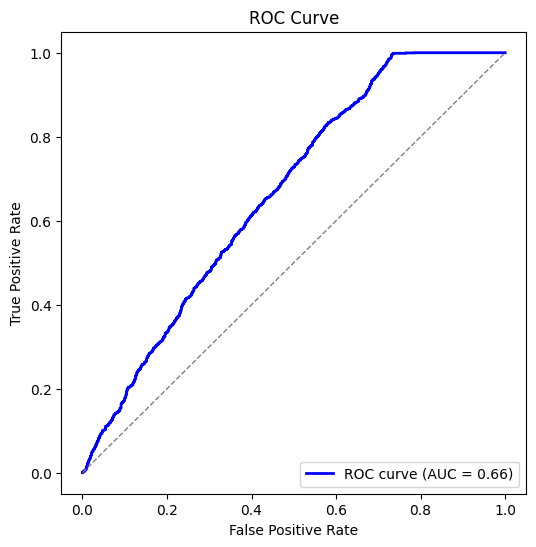

In [29]:
# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0,1],[0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()